In [1]:
import tensorflow_probability as tfp
tfd = tfp.distributions
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import seaborn as sns
import numpy as np
import tqdm
import maxentep
# disabling gpu for now
import os, sys
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
EPS = np.finfo(np.float32).tiny
param_batch_size = 1024
maxent_batch_size = 32
sns.set_context('notebook')

## Toy Model Example

### Make Joint

In [2]:
x = np.array([1., 1.])
i = tf.keras.Input((1,))
l = maxentep.TrainableInputLayer(x)(i)
d = tfp.layers.DistributionLambda(lambda x: tfd.Normal(loc=x[...,0], scale=tf.math.exp(x[...,1])))(l)

In [3]:
model = maxentep.ParameterJoint([lambda x: x], inputs=i, outputs=[d])
model.compile(tf.keras.optimizers.Adam(0.1))
model.summary()

Model: "parameter_joint"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
trainable_input_layer (Train (None, 2)                 2         
_________________________________________________________________
distribution_lambda (Distrib ((None,), (None,))        0         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


In [4]:
model(tf.constant([1.]))

<tfp.distributions.Normal 'parameter_joint_distribution_lambda_Normal' batch_shape=[1] event_shape=[] dtype=float32>

In [5]:
def simulate(x):
    y = np.random.normal(loc=x, scale=0.1)
    return y

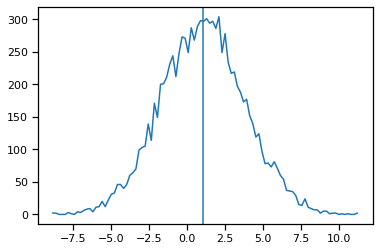

In [6]:
unbiased_params = model.sample(10000)
y = simulate(*unbiased_params)
grid,bins = np.histogram(y, bins=100)
plt.plot((bins[1:] + bins[:-1]) / 2, grid)
plt.axvline(np.mean(np.squeeze(y)))

## Make Constraints

In [7]:
r = maxentep.Restraint(lambda x: x, -5, maxentep.EmptyPrior())

## Maxent without hyper training

In [8]:
me_model = maxentep.MaxentModel([r])
me_model.compile(tf.keras.optimizers.Adam(0.01), 'mean_squared_error')
result = me_model.fit(y, epochs=4)

Epoch 1/4
313/313 [==============================] - 0s 603us/step - loss: 7.5384 - weight-entropy: 2.1844
Epoch 2/4
313/313 [==============================] - 0s 587us/step - loss: 3.0362 - weight-entropy: 1.2921
Epoch 3/4
313/313 [==============================] - 0s 639us/step - loss: 2.5891 - weight-entropy: 1.0099
Epoch 4/4
313/313 [==============================] - 0s 581us/step - loss: 2.6713 - weight-entropy: 0.9229


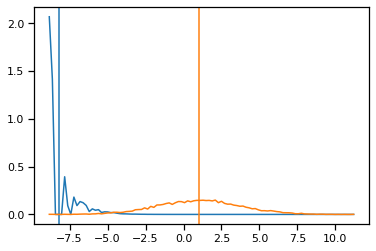

In [9]:
grid,bins = np.histogram(np.squeeze(y), bins=100, weights=me_model.traj_weights, density=True)
plt.plot((bins[1:] + bins[:-1]) / 2, grid)
plt.axvline(np.sum(np.squeeze(y) * me_model.traj_weights))

grid,bins = np.histogram(np.squeeze(y), bins=100, density=True)
plt.plot((bins[1:] + bins[:-1]) / 2, grid, color='C1')
plt.axvline(np.mean(np.squeeze(y)), color='C1')

In [10]:
hme_model = maxentep.HyperMaxentModel([r], model, simulate)
hme_model.compile(tf.keras.optimizers.Adam(0.01), 'mean_squared_error')
result = hme_model.fit(epochs=4)

Epoch 1/4
8/8 [==============================] - 0s 750us/step - loss: 34.2540 - weight-entropy: 3.4602
Epoch 2/4
8/8 [==============================] - 0s 875us/step - loss: 28.2207 - weight-entropy: 3.4195
Epoch 3/4
8/8 [==============================] - 0s 626us/step - loss: 23.0939 - weight-entropy: 3.3426
Epoch 4/4
8/8 [==============================] - 0s 625us/step - loss: 18.3034 - weight-entropy: 3.2226
Epoch 1/4
8/8 [==============================] - 0s 625us/step - loss: 0.3305
Epoch 2/4
8/8 [==============================] - 0s 625us/step - loss: 0.3148
Epoch 3/4
8/8 [==============================] - 0s 625us/step - loss: 0.3078
Epoch 4/4
8/8 [==============================] - 0s 625us/step - loss: 0.3020
Epoch 1/4
8/8 [==============================] - 0s 750us/step - loss: 13.6754 - weight-entropy: 3.4426
Epoch 2/4
8/8 [==============================] - 0s 750us/step - loss: 10.7442 - weight-entropy: 3.3889
Epoch 3/4
8/8 [==============================] - 0s 750us/step -

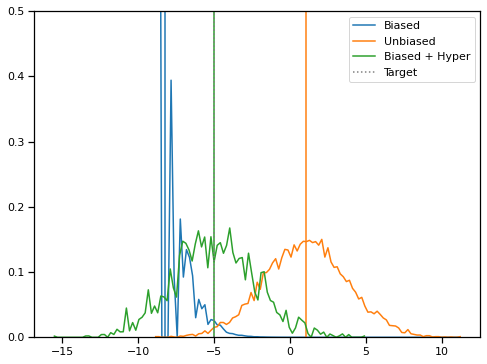

In [11]:
plt.figure(figsize=(8,6))
grid,bins = np.histogram(np.squeeze(y), bins=100, weights=me_model.traj_weights, density=True)
plt.plot((bins[1:] + bins[:-1]) / 2, grid, label='Biased')
plt.axvline(np.sum(np.squeeze(y) * me_model.traj_weights))

grid,bins = np.histogram(np.squeeze(y), bins=100, density=True)
plt.plot((bins[1:] + bins[:-1]) / 2, grid, color='C1', label='Unbiased')
plt.axvline(np.mean(np.squeeze(y)), color='C1')

yp = np.squeeze(hme_model.trajs)
grid,bins = np.histogram(yp, bins=100, density=True, weights=hme_model.traj_weights)
plt.plot((bins[1:] + bins[:-1]) / 2, grid, color='C2', label='Biased + Hyper')
plt.axvline(np.sum(np.squeeze(yp) * hme_model.traj_weights), color='C2')

plt.axvline(x=r.target, color='Gray', linestyle=':', label='Target')
plt.ylim(0,0.5)
plt.legend()

## Examine Training Progress

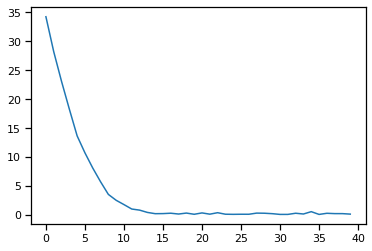

In [12]:
plt.plot(result.history['loss'])

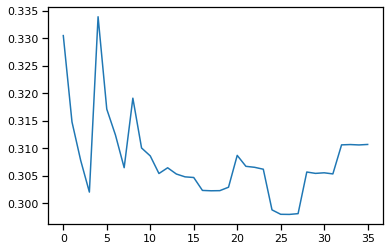

In [13]:
plt.plot(result.history['prior-loss'])

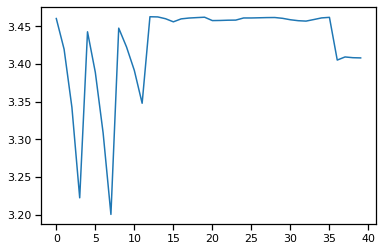

In [14]:
plt.plot(result.history['weight-entropy'])

## Set-up Starting Dist

In [15]:
M = 3
R = np.abs(np.random.normal(size=(M,M), loc=1.25))
R = R / np.sum(R, axis=1).reshape(M,1)
R, np.sum(R, axis=1)

(array([[0.16185759, 0.06411552, 0.77402689],
        [0.40454222, 0.36275287, 0.23270491],
        [0.38765328, 0.27085362, 0.3414931 ]]),
 array([1., 1., 1.]))

In [16]:
# compartment parameters
compartments = ['E', 'A', 'I', 'R']
C = len(compartments)
tmat = maxentep.TransitionMatrix(compartments, [1,2])
tmat.add_transition('E', 'A', 5, 3)
tmat.add_transition('A', 'I', 3, 2)
tmat.add_transition('I', 'R', 14, 5)

In [17]:
start_logits = np.ones((M,))

## Set-up unbiased Joint

In [18]:
unbiased_model = maxentep.MetaParameterJoint(start_logits, R, tmat, name='unbiased')
unbiased_model(tf.constant([1.]))

[<tfp.distributions.Independent 'unbiased_model_R_dist_dist_Independentunbiased_model_R_dist_dist_TruncatedNormal' batch_shape=[] event_shape=[3, 3] dtype=float32>,
 <tfp.distributions.Independent 'unbiased_model_T_dist_dist_Independentunbiased_model_T_dist_dist_unbiased_model_T_dist_dist_reciprocalunbiased_model_T_dist_dist_TruncatedNormal' batch_shape=[] event_shape=[3] dtype=float32>,
 <tfp.distributions.Blockwise 'unbiased_model_rho_dist_dist_Blockwise' batch_shape=[] event_shape=[6] dtype=float32>,
 <tfp.distributions.Independent 'unbiased_model_beta_dist_Independentunbiased_model_beta_dist_TruncatedNormal' batch_shape=[] event_shape=[1] dtype=float32>]

## Create Trainable Joint

In [19]:
model = maxentep.MetaParameterJoint(start_logits, R, tmat, name='param-model')

## Set-up loglikelihood

In [20]:
model.compile(tf.optimizers.Nadam(0.1))
model.summary()

Model: "param-model-model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
R-dist-hypers (TrainableInputLa (None, 2, 3, 3)      18          input_3[0][0]                    
__________________________________________________________________________________________________
R-dist-jitter (Lambda)          (None, 2, 3, 3)      0           R-dist-hypers[0][0]              
__________________________________________________________________________________________________
T-dist-hypers (TrainableInputLa (None, 2, 4, 4)      32          input_3[0][0]                    
__________________________________________________________________________________

## Test out the prior distributions

In [21]:
p = model(tf.constant([1.]))
p

[<tfp.distributions.Independent 'param_model_model_R_dist_dist_Independentparam_model_model_R_dist_dist_TruncatedNormal' batch_shape=[] event_shape=[3, 3] dtype=float32>,
 <tfp.distributions.Independent 'param_model_model_T_dist_dist_Independentparam_model_model_T_dist_dist_param_model_model_T_dist_dist_reciprocalparam_model_model_T_dist_dist_TruncatedNormal' batch_shape=[] event_shape=[3] dtype=float32>,
 <tfp.distributions.Blockwise 'param_model_model_rho_dist_dist_Blockwise' batch_shape=[] event_shape=[6] dtype=float32>,
 <tfp.distributions.Independent 'param_model_model_beta_dist_Independentparam_model_model_beta_dist_TruncatedNormal' batch_shape=[] event_shape=[1] dtype=float32>]

In [22]:
p[1]

<tfp.distributions.Independent 'param_model_model_T_dist_dist_Independentparam_model_model_T_dist_dist_param_model_model_T_dist_dist_reciprocalparam_model_model_T_dist_dist_TruncatedNormal' batch_shape=[] event_shape=[3] dtype=float32>

In [23]:
p[1].sample(2)
p[1].log_prob(p[1].sample(2))

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([2.5440974, 5.3304663], dtype=float32)>

In [24]:
s = [x.sample(2) for x in p]
print(s)

[<tf.Tensor: shape=(2, 3, 3), dtype=float32, numpy=
array([[[0.5691886 , 0.62657475, 0.8240549 ],
        [0.60440767, 0.31704932, 0.62513983],
        [1.1747653 , 0.66299   , 2.0080602 ]],

       [[0.33573198, 0.8307088 , 1.4554667 ],
        [0.17714545, 0.57535684, 0.1379248 ],
        [0.81811523, 0.17542759, 0.8154541 ]]], dtype=float32)>, <tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[0.3145122 , 0.20695792, 0.14514425],
       [0.36154625, 0.41428956, 0.06341862]], dtype=float32)>, <tf.Tensor: shape=(2, 6), dtype=float32, numpy=
array([[1.        , 1.        , 1.        , 0.1910342 , 0.1308828 ,
        0.14024556],
       [0.        , 0.        , 0.        , 0.39965278, 0.45185   ,
        0.365907  ]], dtype=float32)>, <tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[0.06797128],
       [0.10404044]], dtype=float32)>]


In [25]:
p[1].log_prob(s[1])

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([1.8243258, 3.0453806], dtype=float32)>

In [26]:
p[1]

<tfp.distributions.Independent 'param_model_model_T_dist_dist_Independentparam_model_model_T_dist_dist_param_model_model_T_dist_dist_reciprocalparam_model_model_T_dist_dist_TruncatedNormal' batch_shape=[] event_shape=[3] dtype=float32>

In [27]:
[pi.log_prob(si) for pi, si in zip(p, s)]

[<tf.Tensor: shape=(2,), dtype=float32, numpy=array([-6.775874, -2.451164], dtype=float32)>,
 <tf.Tensor: shape=(2,), dtype=float32, numpy=array([1.8243258, 3.0453806], dtype=float32)>,
 <tf.Tensor: shape=(2,), dtype=float32, numpy=array([ 1.3443815, -2.1498022], dtype=float32)>,
 <tf.Tensor: shape=(2,), dtype=float32, numpy=array([2.0258224, 2.0965648], dtype=float32)>]

In [28]:
model.evaluate(tf.constant([1., 1.]), s)

1/1 [==============================] - 0s 999us/step - loss: -1.5410 - R-dist-dist_loss: 4.6135 - T-dist-dist_loss: -2.4349 - rho-dist-dist_loss: 0.4027 - beta-dist_loss: -4.1224


[-1.541010856628418,
 4.613518714904785,
 -2.4348530769348145,
 0.402710497379303,
 -4.122386932373047]

## Sampling Functions

In [29]:
v = model.sample(2)
v

[<tf.Tensor: shape=(2, 3, 3), dtype=float32, numpy=
 array([[[0.5731483 , 0.6651318 , 0.33234933],
         [0.38286173, 0.9361524 , 0.27589053],
         [1.1026288 , 0.00447726, 1.1734502 ]],
 
        [[0.3166349 , 0.6517709 , 0.65860426],
         [0.61008346, 0.31995153, 0.16654605],
         [0.3251592 , 0.7290776 , 0.5649723 ]]], dtype=float32)>,
 <tf.Tensor: shape=(2, 4, 4), dtype=float32, numpy=
 array([[[0.24019772, 0.7598023 , 0.        , 0.        ],
         [0.        , 0.6905867 , 0.30941328, 0.        ],
         [0.        , 0.        , 0.91579384, 0.08420616],
         [0.        , 0.        , 0.        , 1.        ]],
 
        [[0.7314881 , 0.2685119 , 0.        , 0.        ],
         [0.        , 0.6712165 , 0.32878354, 0.        ],
         [0.        , 0.        , 0.93649536, 0.06350462],
         [0.        , 0.        , 0.        , 1.        ]]], dtype=float32)>,
 <tf.Tensor: shape=(2, 3, 4), dtype=float32, numpy=
 array([[[0.2520516 , 0.        , 0.        , 

c:\users\white\maxent\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explcit keyword will result in an error or misinterpretation.
  FutureWarning


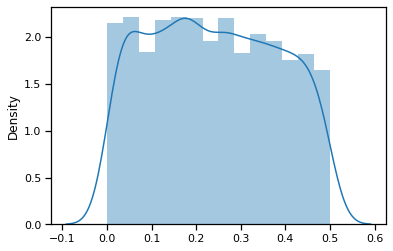

In [30]:
# sample start
s = model.sample(1000)[2].numpy().flatten()
sns.distplot(s[s > 0])

## Make some restraints

In [31]:
r1 = maxentep.Restraint(lambda x: x[...,25,0,2], 0.4, maxentep.EmptyPrior())
r2 = maxentep.Restraint(lambda x: x[...,50,0,2], 0.2, maxentep.EmptyPrior())

## Make Metapopulation Model

In [32]:
meta_model = maxentep.MetaModel(maxentep.contact_infection_func([1,2]), 150)

## Maxent Model

In [33]:
maxent_model = maxentep.MaxentModel([r1, r2])
maxent_model.compile(tf.keras.optimizers.Adam(learning_rate=1e-2), 'mean_squared_error')

## Visualize Unbiased

Text(0.5, 1.0, 'Unbiased Result')

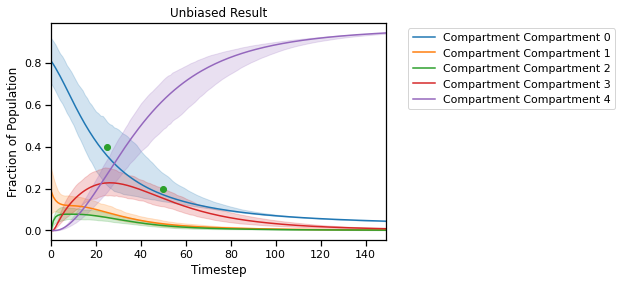

In [34]:
psample = unbiased_model.sample(param_batch_size)
trajs = meta_model(*psample)
maxentep.traj_quantile(trajs[:,:,0,:])
plt.plot(25, r1.target, 'o', color='C2')
plt.plot(50, r2.target, 'o', color='C2')
plt.title('Unbiased Result')

## Try to reweight without hyper-parameter tuning

In [35]:
me_loss = []
# sample and get batch
psample = unbiased_model.sample(param_batch_size)
trajs = meta_model(*psample)
# get weights of trajectories
h = maxent_model.fit(trajs, batch_size=maxent_batch_size, epochs=128, verbose=False)
me_loss.extend(h.history['loss'])
w = maxent_model.traj_weights

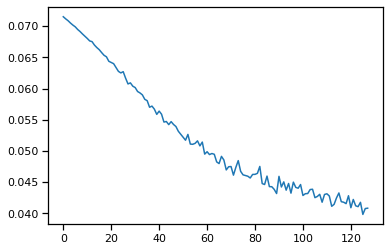

In [36]:
plt.plot(me_loss)
plt.show()

Text(0.5, 1.0, 'Maxent Result')

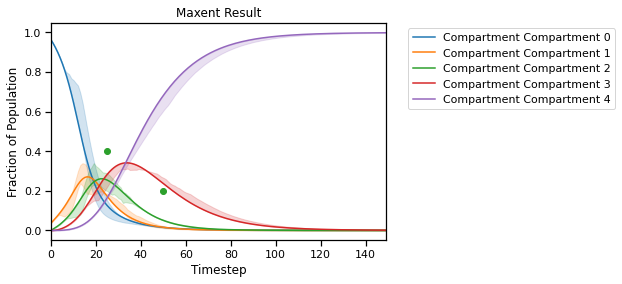

In [37]:
maxentep.traj_quantile(trajs[:,:,0,:], weights=w)
plt.plot(25, r1.target, 'o', color='C2')
plt.plot(50, r2.target, 'o', color='C2')
plt.title('Maxent Result')

## Now tune hyperparameters at the same time

In [38]:
maxent_hyper_model = maxentep.HyperMaxentModel([r1, r2], model, meta_model)
maxent_hyper_model.compile(tf.keras.optimizers.Adam(learning_rate=1e-2), 'mean_squared_error')
result = maxent_hyper_model.fit(param_batch_size, outter_epochs=64, batch_size=32, epochs=8)

Epoch 1/8
32/32 [==============================] - 0s 625us/step - loss: 0.0720 - weight-entropy: 3.4657
Epoch 2/8
32/32 [==============================] - 0s 594us/step - loss: 0.0718 - weight-entropy: 3.4654
Epoch 3/8
32/32 [==============================] - 0s 594us/step - loss: 0.0715 - weight-entropy: 3.4648
Epoch 4/8
32/32 [==============================] - 0s 562us/step - loss: 0.0711 - weight-entropy: 3.4638
Epoch 5/8
32/32 [==============================] - 0s 625us/step - loss: 0.0708 - weight-entropy: 3.4624
Epoch 6/8
32/32 [==============================] - 0s 562us/step - loss: 0.0705 - weight-entropy: 3.4607
Epoch 7/8
32/32 [==============================] - 0s 562us/step - loss: 0.0702 - weight-entropy: 3.4588
Epoch 8/8
32/32 [==============================] - 0s 562us/step - loss: 0.0698 - weight-entropy: 3.4562
Epoch 1/8
32/32 [==============================] - 0s 1ms/step - loss: -0.0549 - R-dist-dist_loss: 0.0032 - T-dist-dist_loss: -0.0035 - rho-dist-dist_loss: -3.4

32/32 [==============================] - 0s 1ms/step - loss: -0.0565 - R-dist-dist_loss: 0.0031 - T-dist-dist_loss: -0.0038 - rho-dist-dist_loss: -3.3656e-04 - beta-dist_loss: -0.0555
Epoch 1/8
32/32 [==============================] - 0s 688us/step - loss: 0.0630 - weight-entropy: 3.3459
Epoch 2/8
32/32 [==============================] - 0s 656us/step - loss: 0.0627 - weight-entropy: 3.3458
Epoch 3/8
32/32 [==============================] - 0s 687us/step - loss: 0.0619 - weight-entropy: 3.3334
Epoch 4/8
32/32 [==============================] - 0s 656us/step - loss: 0.0618 - weight-entropy: 3.3298
Epoch 5/8
32/32 [==============================] - 0s 656us/step - loss: 0.0612 - weight-entropy: 3.3207
Epoch 6/8
32/32 [==============================] - 0s 656us/step - loss: 0.0607 - weight-entropy: 3.3123
Epoch 7/8
32/32 [==============================] - 0s 625us/step - loss: 0.0604 - weight-entropy: 3.3055
Epoch 8/8
32/32 [==============================] - 0s 531us/step - loss: 0.0600 -

32/32 [==============================] - 0s 562us/step - loss: 0.0498 - weight-entropy: 3.1819
Epoch 7/8
32/32 [==============================] - 0s 594us/step - loss: 0.0491 - weight-entropy: 3.1675
Epoch 8/8
32/32 [==============================] - 0s 562us/step - loss: 0.0486 - weight-entropy: 3.1554
Epoch 1/8
32/32 [==============================] - 0s 1ms/step - loss: -0.0561 - R-dist-dist_loss: 0.0032 - T-dist-dist_loss: -0.0041 - rho-dist-dist_loss: -3.1188e-04 - beta-dist_loss: -0.0550
Epoch 2/8
32/32 [==============================] - 0s 1ms/step - loss: -0.0560 - R-dist-dist_loss: 0.0032 - T-dist-dist_loss: -0.0041 - rho-dist-dist_loss: -3.0961e-04 - beta-dist_loss: -0.0548
Epoch 3/8
32/32 [==============================] - 0s 1ms/step - loss: -0.0563 - R-dist-dist_loss: 0.0033 - T-dist-dist_loss: -0.0041 - rho-dist-dist_loss: -3.1395e-04 - beta-dist_loss: -0.0551
Epoch 4/8
32/32 [==============================] - 0s 1ms/step - loss: -0.0561 - R-dist-dist_loss: 0.0032 - T-dis

32/32 [==============================] - 0s 1ms/step - loss: -0.0557 - R-dist-dist_loss: 0.0032 - T-dist-dist_loss: -0.0046 - rho-dist-dist_loss: -2.6914e-04 - beta-dist_loss: -0.0541
Epoch 5/8
32/32 [==============================] - 0s 1ms/step - loss: -0.0555 - R-dist-dist_loss: 0.0032 - T-dist-dist_loss: -0.0046 - rho-dist-dist_loss: -2.7329e-04 - beta-dist_loss: -0.0539
Epoch 6/8
32/32 [==============================] - 0s 1ms/step - loss: -0.0557 - R-dist-dist_loss: 0.0032 - T-dist-dist_loss: -0.0046 - rho-dist-dist_loss: -2.7481e-04 - beta-dist_loss: -0.0540
Epoch 7/8
32/32 [==============================] - 0s 1ms/step - loss: -0.0555 - R-dist-dist_loss: 0.0032 - T-dist-dist_loss: -0.0046 - rho-dist-dist_loss: -2.7303e-04 - beta-dist_loss: -0.0539
Epoch 8/8
32/32 [==============================] - 0s 1ms/step - loss: -0.0553 - R-dist-dist_loss: 0.0032 - T-dist-dist_loss: -0.0046 - rho-dist-dist_loss: -2.7559e-04 - beta-dist_loss: -0.0537
Epoch 1/8
32/32 [=======================

32/32 [==============================] - 0s 625us/step - loss: 0.0261 - weight-entropy: 2.4806
Epoch 2/8
32/32 [==============================] - 0s 562us/step - loss: 0.0262 - weight-entropy: 2.4719
Epoch 3/8
32/32 [==============================] - 0s 563us/step - loss: 0.0258 - weight-entropy: 2.4477
Epoch 4/8
32/32 [==============================] - 0s 594us/step - loss: 0.0260 - weight-entropy: 2.5117
Epoch 5/8
32/32 [==============================] - 0s 531us/step - loss: 0.0263 - weight-entropy: 2.4762
Epoch 6/8
32/32 [==============================] - 0s 594us/step - loss: 0.0250 - weight-entropy: 2.4380
Epoch 7/8
32/32 [==============================] - 0s 562us/step - loss: 0.0256 - weight-entropy: 2.4712
Epoch 8/8
32/32 [==============================] - 0s 562us/step - loss: 0.0252 - weight-entropy: 2.4611
Epoch 1/8
32/32 [==============================] - 0s 1ms/step - loss: -0.0534 - R-dist-dist_loss: 0.0031 - T-dist-dist_loss: -0.0051 - rho-dist-dist_loss: -3.3065e-04 - 

32/32 [==============================] - 0s 563us/step - loss: 0.0192 - weight-entropy: 2.4507
Epoch 1/8
32/32 [==============================] - 0s 1ms/step - loss: -0.0592 - R-dist-dist_loss: 0.0036 - T-dist-dist_loss: -0.0049 - rho-dist-dist_loss: -3.7304e-04 - beta-dist_loss: -0.0575
Epoch 2/8
32/32 [==============================] - 0s 1ms/step - loss: -0.0585 - R-dist-dist_loss: 0.0040 - T-dist-dist_loss: -0.0050 - rho-dist-dist_loss: -3.4030e-04 - beta-dist_loss: -0.0572
Epoch 3/8
32/32 [==============================] - 0s 1ms/step - loss: -0.0597 - R-dist-dist_loss: 0.0035 - T-dist-dist_loss: -0.0050 - rho-dist-dist_loss: -3.9667e-04 - beta-dist_loss: -0.0577
Epoch 4/8
32/32 [==============================] - 0s 1ms/step - loss: -0.0594 - R-dist-dist_loss: 0.0035 - T-dist-dist_loss: -0.0050 - rho-dist-dist_loss: -3.6778e-04 - beta-dist_loss: -0.0575
Epoch 5/8
32/32 [==============================] - 0s 1ms/step - loss: -0.0604 - R-dist-dist_loss: 0.0034 - T-dist-dist_loss: -0.

32/32 [==============================] - 0s 1ms/step - loss: -0.0600 - R-dist-dist_loss: 0.0034 - T-dist-dist_loss: -0.0055 - rho-dist-dist_loss: -1.8881e-04 - beta-dist_loss: -0.0577
Epoch 5/8
32/32 [==============================] - 0s 1ms/step - loss: -0.0603 - R-dist-dist_loss: 0.0033 - T-dist-dist_loss: -0.0056 - rho-dist-dist_loss: -2.0405e-04 - beta-dist_loss: -0.0579
Epoch 6/8
32/32 [==============================] - 0s 1ms/step - loss: -0.0598 - R-dist-dist_loss: 0.0033 - T-dist-dist_loss: -0.0056 - rho-dist-dist_loss: -2.0835e-04 - beta-dist_loss: -0.0573
Epoch 7/8
32/32 [==============================] - 0s 1ms/step - loss: -0.0600 - R-dist-dist_loss: 0.0034 - T-dist-dist_loss: -0.0056 - rho-dist-dist_loss: -2.1052e-04 - beta-dist_loss: -0.0576
Epoch 8/8
32/32 [==============================] - 0s 1ms/step - loss: -0.0600 - R-dist-dist_loss: 0.0033 - T-dist-dist_loss: -0.0056 - rho-dist-dist_loss: -2.1059e-04 - beta-dist_loss: -0.0576
Epoch 1/8
32/32 [=======================

32/32 [==============================] - 0s 1ms/step - loss: -0.0609 - R-dist-dist_loss: 0.0038 - T-dist-dist_loss: -0.0058 - rho-dist-dist_loss: -2.2337e-04 - beta-dist_loss: -0.0587
Epoch 8/8
32/32 [==============================] - 0s 1ms/step - loss: -0.0604 - R-dist-dist_loss: 0.0038 - T-dist-dist_loss: -0.0058 - rho-dist-dist_loss: -2.3797e-04 - beta-dist_loss: -0.0582
Epoch 1/8
32/32 [==============================] - 0s 750us/step - loss: 0.0104 - weight-entropy: 1.8015
Epoch 2/8
32/32 [==============================] - 0s 781us/step - loss: 0.0101 - weight-entropy: 1.7414
Epoch 3/8
32/32 [==============================] - 0s 750us/step - loss: 0.0103 - weight-entropy: 1.7628
Epoch 4/8
32/32 [==============================] - 0s 687us/step - loss: 0.0102 - weight-entropy: 1.6624
Epoch 5/8
32/32 [==============================] - 0s 594us/step - loss: 0.0107 - weight-entropy: 1.7009
Epoch 6/8
32/32 [==============================] - 0s 625us/step - loss: 0.0100 - weight-entropy:

32/32 [==============================] - 0s 781us/step - loss: 0.0102 - weight-entropy: 1.8277
Epoch 8/8
32/32 [==============================] - 0s 781us/step - loss: 0.0099 - weight-entropy: 1.8616
Epoch 1/8
32/32 [==============================] - 0s 1ms/step - loss: -0.0612 - R-dist-dist_loss: 0.0030 - T-dist-dist_loss: -0.0048 - rho-dist-dist_loss: 3.4194e-04 - beta-dist_loss: -0.0597
Epoch 2/8
32/32 [==============================] - 0s 1ms/step - loss: -0.0622 - R-dist-dist_loss: 0.0026 - T-dist-dist_loss: -0.0050 - rho-dist-dist_loss: -3.0340e-06 - beta-dist_loss: -0.0598
Epoch 3/8
32/32 [==============================] - 0s 1ms/step - loss: -0.0623 - R-dist-dist_loss: 0.0027 - T-dist-dist_loss: -0.0051 - rho-dist-dist_loss: -3.7848e-05 - beta-dist_loss: -0.0599
Epoch 4/8
32/32 [==============================] - 0s 1ms/step - loss: -0.0623 - R-dist-dist_loss: 0.0027 - T-dist-dist_loss: -0.0050 - rho-dist-dist_loss: 4.0370e-06 - beta-dist_loss: -0.0600
Epoch 5/8
32/32 [=========

32/32 [==============================] - 0s 2ms/step - loss: -0.0418 - R-dist-dist_loss: 0.0024 - T-dist-dist_loss: -0.0039 - rho-dist-dist_loss: -7.7496e-04 - beta-dist_loss: -0.0396
Epoch 4/8
32/32 [==============================] - 0s 1ms/step - loss: -0.0142 - R-dist-dist_loss: 0.0035 - T-dist-dist_loss: -0.0040 - rho-dist-dist_loss: -7.5278e-04 - beta-dist_loss: -0.0129
Epoch 5/8
32/32 [==============================] - 0s 1ms/step - loss: -0.0513 - R-dist-dist_loss: 0.0028 - T-dist-dist_loss: -0.0042 - rho-dist-dist_loss: -7.6090e-04 - beta-dist_loss: -0.0492
Epoch 6/8
32/32 [==============================] - 0s 1ms/step - loss: -0.0179 - R-dist-dist_loss: 0.0026 - T-dist-dist_loss: -0.0043 - rho-dist-dist_loss: -7.6964e-04 - beta-dist_loss: -0.0155    
Epoch 7/8
32/32 [==============================] - 0s 1ms/step - loss: -0.0322 - R-dist-dist_loss: 0.0032 - T-dist-dist_loss: -0.0043 - rho-dist-dist_loss: -7.7969e-04 - beta-dist_loss: -0.0302
Epoch 8/8
32/32 [===================

32/32 [==============================] - 0s 1ms/step - loss: -0.0500 - R-dist-dist_loss: 0.0031 - T-dist-dist_loss: -0.0051 - rho-dist-dist_loss: -0.0013 - beta-dist_loss: -0.0466        
Epoch 7/8
32/32 [==============================] - 0s 1ms/step - loss: -0.0501 - R-dist-dist_loss: 0.0028 - T-dist-dist_loss: -0.0051 - rho-dist-dist_loss: -0.0013 - beta-dist_loss: -0.0465
Epoch 8/8
32/32 [==============================] - 0s 1ms/step - loss: -0.0509 - R-dist-dist_loss: 0.0030 - T-dist-dist_loss: -0.0051 - rho-dist-dist_loss: -0.0013 - beta-dist_loss: -0.0475
Epoch 1/8
32/32 [==============================] - 0s 656us/step - loss: 0.0083 - weight-entropy: 1.3642
Epoch 2/8
32/32 [==============================] - 0s 594us/step - loss: 0.0076 - weight-entropy: 1.4063
Epoch 3/8
32/32 [==============================] - 0s 594us/step - loss: 0.0085 - weight-entropy: 1.3321
Epoch 4/8
32/32 [==============================] - 0s 594us/step - loss: 0.0081 - weight-entropy: 1.4236
Epoch 5/8
32

32/32 [==============================] - 0s 594us/step - loss: 0.0061 - weight-entropy: 1.5505
Epoch 3/8
32/32 [==============================] - 0s 562us/step - loss: 0.0065 - weight-entropy: 1.6926
Epoch 4/8
32/32 [==============================] - 0s 563us/step - loss: 0.0057 - weight-entropy: 1.5688
Epoch 5/8
32/32 [==============================] - 0s 583us/step - loss: 0.0060 - weight-entropy: 1.6266
Epoch 6/8
32/32 [==============================] - 0s 563us/step - loss: 0.0066 - weight-entropy: 1.6125
Epoch 7/8
32/32 [==============================] - 0s 562us/step - loss: 0.0060 - weight-entropy: 1.5625
Epoch 8/8
32/32 [==============================] - 0s 594us/step - loss: 0.0062 - weight-entropy: 1.5863
Epoch 1/8
32/32 [==============================] - 0s 1ms/step - loss: -0.0533 - R-dist-dist_loss: 0.0035 - T-dist-dist_loss: -0.0055 - rho-dist-dist_loss: -7.9715e-04 - beta-dist_loss: -0.0504
Epoch 2/8
32/32 [==============================] - 0s 1ms/step - loss: -0.0535 - 

32/32 [==============================] - 0s 1ms/step - loss: -0.0547 - R-dist-dist_loss: 0.0044 - T-dist-dist_loss: -0.0054 - rho-dist-dist_loss: -5.4253e-04 - beta-dist_loss: -0.0532
Epoch 2/8
32/32 [==============================] - 0s 1ms/step - loss: -0.0538 - R-dist-dist_loss: 0.0040 - T-dist-dist_loss: -0.0054 - rho-dist-dist_loss: -5.8650e-04 - beta-dist_loss: -0.0518
Epoch 3/8
32/32 [==============================] - 0s 1ms/step - loss: -0.0547 - R-dist-dist_loss: 0.0037 - T-dist-dist_loss: -0.0055 - rho-dist-dist_loss: -5.8172e-04 - beta-dist_loss: -0.0524
Epoch 4/8
32/32 [==============================] - 0s 1ms/step - loss: -0.0515 - R-dist-dist_loss: 0.0038 - T-dist-dist_loss: -0.0055 - rho-dist-dist_loss: -5.7524e-04 - beta-dist_loss: -0.0493
Epoch 5/8
32/32 [==============================] - 0s 1ms/step - loss: -0.0536 - R-dist-dist_loss: 0.0039 - T-dist-dist_loss: -0.0055 - rho-dist-dist_loss: -5.7103e-04 - beta-dist_loss: -0.0514
Epoch 6/8
32/32 [=======================

32/32 [==============================] - 0s 1ms/step - loss: -0.0657 - R-dist-dist_loss: 0.0022 - T-dist-dist_loss: -0.0069 - rho-dist-dist_loss: -0.0020 - beta-dist_loss: -0.0590        
Epoch 5/8
32/32 [==============================] - 0s 1ms/step - loss: -0.0682 - R-dist-dist_loss: 0.0025 - T-dist-dist_loss: -0.0070 - rho-dist-dist_loss: -0.0020 - beta-dist_loss: -0.0616
Epoch 6/8
32/32 [==============================] - 0s 1ms/step - loss: -0.0680 - R-dist-dist_loss: 0.0026 - T-dist-dist_loss: -0.0072 - rho-dist-dist_loss: -0.0020 - beta-dist_loss: -0.0613                
Epoch 7/8
32/32 [==============================] - 0s 1ms/step - loss: -0.0688 - R-dist-dist_loss: 0.0022 - T-dist-dist_loss: -0.0073 - rho-dist-dist_loss: -0.0020 - beta-dist_loss: -0.0617                
Epoch 8/8
32/32 [==============================] - 0s 1ms/step - loss: -0.0692 - R-dist-dist_loss: 0.0023 - T-dist-dist_loss: -0.0075 - rho-dist-dist_loss: -0.0020 - beta-dist_loss: -0.0620                
Epoc

32/32 [==============================] - 0s 625us/step - loss: 0.0052 - weight-entropy: 1.4957
Epoch 2/8
32/32 [==============================] - 0s 687us/step - loss: 0.0051 - weight-entropy: 1.5840
Epoch 3/8
32/32 [==============================] - 0s 688us/step - loss: 0.0048 - weight-entropy: 1.6040
Epoch 4/8
32/32 [==============================] - 0s 688us/step - loss: 0.0055 - weight-entropy: 1.4290
Epoch 5/8
32/32 [==============================] - 0s 656us/step - loss: 0.0054 - weight-entropy: 1.5252
Epoch 6/8
32/32 [==============================] - 0s 656us/step - loss: 0.0049 - weight-entropy: 1.5652
Epoch 7/8
32/32 [==============================] - 0s 687us/step - loss: 0.0054 - weight-entropy: 1.5514
Epoch 8/8
32/32 [==============================] - 0s 656us/step - loss: 0.0054 - weight-entropy: 1.6116
Epoch 1/8
32/32 [==============================] - 0s 1ms/step - loss: -0.0554 - R-dist-dist_loss: 0.0038 - T-dist-dist_loss: -0.0057 - rho-dist-dist_loss: 0.0033 - beta-

32/32 [==============================] - 0s 1ms/step - loss: -0.0496 - R-dist-dist_loss: 0.0034 - T-dist-dist_loss: -0.0061 - rho-dist-dist_loss: -5.7687e-04 - beta-dist_loss: -0.0463
Epoch 2/8
32/32 [==============================] - 0s 1ms/step - loss: -0.0503 - R-dist-dist_loss: 0.0032 - T-dist-dist_loss: -0.0062 - rho-dist-dist_loss: -6.0357e-04 - beta-dist_loss: -0.0466
Epoch 3/8
32/32 [==============================] - 0s 1ms/step - loss: -0.0496 - R-dist-dist_loss: 0.0032 - T-dist-dist_loss: -0.0062 - rho-dist-dist_loss: -6.0857e-04 - beta-dist_loss: -0.0460   
Epoch 4/8
32/32 [==============================] - 0s 1ms/step - loss: -0.0473 - R-dist-dist_loss: 0.0032 - T-dist-dist_loss: -0.0062 - rho-dist-dist_loss: -6.4086e-04 - beta-dist_loss: -0.0436
Epoch 5/8
32/32 [==============================] - 0s 1ms/step - loss: -0.0460 - R-dist-dist_loss: 0.0032 - T-dist-dist_loss: -0.0062 - rho-dist-dist_loss: -6.5029e-04 - beta-dist_loss: -0.0423
Epoch 6/8
32/32 [====================

32/32 [==============================] - 0s 1ms/step - loss: -0.0600 - R-dist-dist_loss: 0.0045 - T-dist-dist_loss: -0.0052 - rho-dist-dist_loss: -0.0024 - beta-dist_loss: -0.0569
Epoch 7/8
32/32 [==============================] - 0s 1ms/step - loss: -0.0629 - R-dist-dist_loss: 0.0043 - T-dist-dist_loss: -0.0053 - rho-dist-dist_loss: -0.0025 - beta-dist_loss: -0.0594               
Epoch 8/8
32/32 [==============================] - 0s 1ms/step - loss: -0.0651 - R-dist-dist_loss: 0.0046 - T-dist-dist_loss: -0.0052 - rho-dist-dist_loss: -0.0027 - beta-dist_loss: -0.0617   
Epoch 1/8
32/32 [==============================] - 0s 562us/step - loss: 0.0085 - weight-entropy: 0.8690
Epoch 2/8
32/32 [==============================] - 0s 563us/step - loss: 0.0084 - weight-entropy: 0.9497
Epoch 3/8
32/32 [==============================] - 0s 531us/step - loss: 0.0078 - weight-entropy: 0.8472
Epoch 4/8
32/32 [==============================] - 0s 562us/step - loss: 0.0083 - weight-entropy: 0.8711
Ep

32/32 [==============================] - 0s 562us/step - loss: 0.0058 - weight-entropy: 1.0311
Epoch 5/8
32/32 [==============================] - 0s 562us/step - loss: 0.0055 - weight-entropy: 1.0757
Epoch 6/8
32/32 [==============================] - 0s 594us/step - loss: 0.0050 - weight-entropy: 1.1116
Epoch 7/8
32/32 [==============================] - 0s 562us/step - loss: 0.0048 - weight-entropy: 1.0193
Epoch 8/8
32/32 [==============================] - 0s 594us/step - loss: 0.0044 - weight-entropy: 0.9952
Epoch 1/8
32/32 [==============================] - 0s 1ms/step - loss: -0.0521 - R-dist-dist_loss: 0.0050 - T-dist-dist_loss: -0.0053 - rho-dist-dist_loss: -5.2545e-04 - beta-dist_loss: -0.0512
Epoch 2/8
32/32 [==============================] - 0s 1ms/step - loss: -0.0525 - R-dist-dist_loss: 0.0045 - T-dist-dist_loss: -0.0056 - rho-dist-dist_loss: -5.5471e-04 - beta-dist_loss: -0.0508
Epoch 3/8
32/32 [==============================] - 0s 1ms/step - loss: -0.0564 - R-dist-dist_loss

32/32 [==============================] - 0s 1ms/step - loss: -0.0552 - R-dist-dist_loss: 0.0030 - T-dist-dist_loss: -0.0049 - rho-dist-dist_loss: -1.3649e-04 - beta-dist_loss: -0.0531   
Epoch 4/8
32/32 [==============================] - 0s 1ms/step - loss: -0.0563 - R-dist-dist_loss: 0.0027 - T-dist-dist_loss: -0.0049 - rho-dist-dist_loss: -1.3094e-04 - beta-dist_loss: -0.0540   
Epoch 5/8
32/32 [==============================] - 0s 1ms/step - loss: -0.0574 - R-dist-dist_loss: 0.0026 - T-dist-dist_loss: -0.0049 - rho-dist-dist_loss: -1.2652e-04 - beta-dist_loss: -0.0550
Epoch 6/8
32/32 [==============================] - 0s 1ms/step - loss: -0.0519 - R-dist-dist_loss: 0.0030 - T-dist-dist_loss: -0.0049 - rho-dist-dist_loss: -1.7078e-05 - beta-dist_loss: -0.0499
Epoch 7/8
32/32 [==============================] - 0s 1ms/step - loss: -0.0539 - R-dist-dist_loss: 0.0026 - T-dist-dist_loss: -0.0050 - rho-dist-dist_loss: -1.6169e-04 - beta-dist_loss: -0.0514   
Epoch 8/8
32/32 [==============

32/32 [==============================] - 0s 1ms/step - loss: -0.0598 - R-dist-dist_loss: 0.0030 - T-dist-dist_loss: -0.0059 - rho-dist-dist_loss: -5.9337e-04 - beta-dist_loss: -0.0563
Epoch 1/8
128/128 [==============================] - 0s 570us/step - loss: 0.0045 - weight-entropy: 1.4736
Epoch 2/8
128/128 [==============================] - 0s 570us/step - loss: 0.0046 - weight-entropy: 1.5215
Epoch 3/8
128/128 [==============================] - 0s 609us/step - loss: 0.0044 - weight-entropy: 1.5337
Epoch 4/8
128/128 [==============================] - 0s 641us/step - loss: 0.0044 - weight-entropy: 1.4728
Epoch 5/8
128/128 [==============================] - 0s 578us/step - loss: 0.0046 - weight-entropy: 1.4747
Epoch 6/8
128/128 [==============================] - 0s 562us/step - loss: 0.0045 - weight-entropy: 1.4750
Epoch 7/8
128/128 [==============================] - 0s 547us/step - loss: 0.0043 - weight-entropy: 1.5047
Epoch 8/8
128/128 [==============================] - 0s 555us/step 

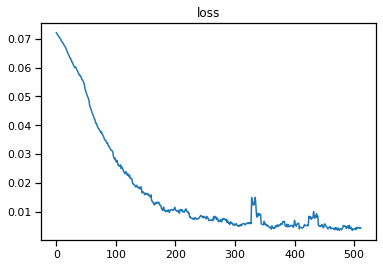

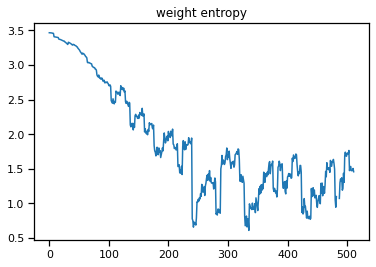

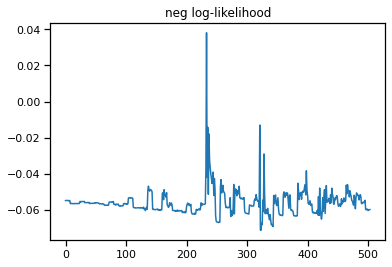

In [39]:
plt.plot(result.history['loss'])
plt.title('loss')
plt.show()

plt.plot(result.history['weight-entropy'])
plt.title('weight entropy')
plt.show()

plt.plot(result.history['prior-loss'])
plt.title('neg log-likelihood')
plt.show()

## Compare Weights

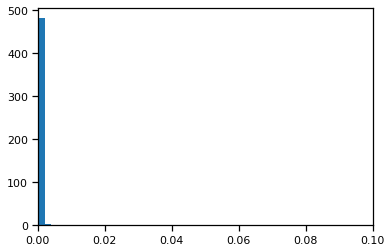

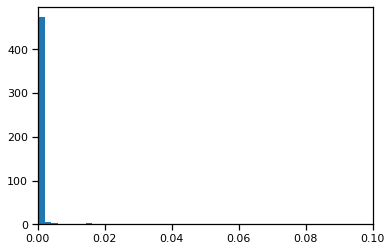

In [40]:
plt.hist(x=maxent_hyper_model.traj_weights, bins=np.linspace(0,0.1,50), density=True)
plt.xlim(0,0.1)
plt.show()
plt.hist(x=maxent_model.traj_weights, bins=np.linspace(0,0.1,50), density=True)
plt.xlim(0,0.1)
plt.show()

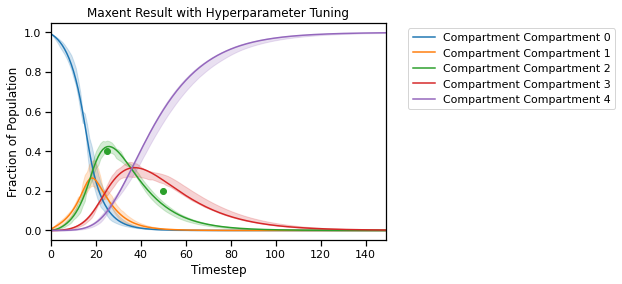

Text(0.5, 1.0, 'Maxent Result with Hyperparameter Tuning - Patch 2')

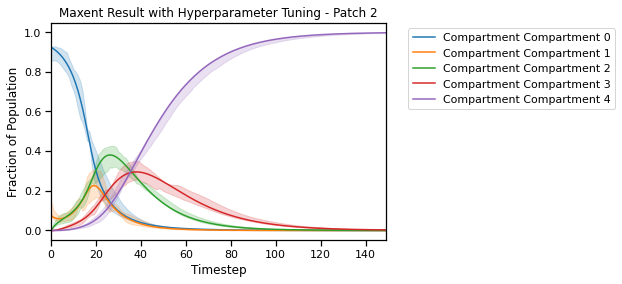

In [41]:
w = maxent_hyper_model.traj_weights
trajs = maxent_hyper_model.trajs
maxentep.traj_quantile(trajs[:,:,0,:], weights=w)
plt.plot(25, r1.target, 'o', color='C2')
plt.plot(50, r2.target, 'o', color='C2')
plt.title('Maxent Result with Hyperparameter Tuning')
plt.show()

maxentep.traj_quantile(trajs[:,:,2,:], weights=w)
plt.title('Maxent Result with Hyperparameter Tuning - Patch 2')

## Compare Hyper-parameter values

<BarContainer object of 32 artists>

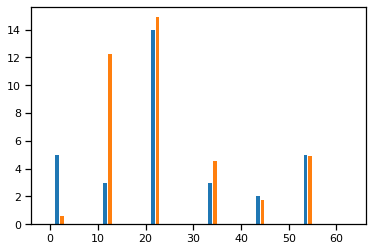

In [42]:
ub = unbiased_model.get_layer('T-dist-hypers').w.numpy().flatten()
b = model.get_layer('T-dist-hypers').w.numpy().flatten()
plt.bar(np.arange(len(ub)) * 2 - 0.5, ub)
plt.bar(np.arange(len(ub)) * 2 + 0.5, b)

<BarContainer object of 3 artists>

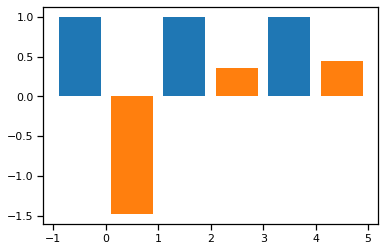

In [43]:
ub = unbiased_model.get_layer('rho-dist-start-logit-hypers').w.numpy().flatten()
b = model.get_layer('rho-dist-start-logit-hypers').w.numpy().flatten()
plt.bar(np.arange(len(ub)) * 2 - 0.5, ub)
plt.bar(np.arange(len(ub)) * 2 + 0.5, b)

<BarContainer object of 2 artists>

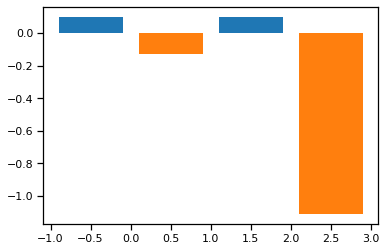

In [44]:
ub = unbiased_model.get_layer('rho-dist-norm-hypers').trainable_variables[0].numpy().flatten()
b = model.get_layer('rho-dist-norm-hypers').trainable_variables[0].numpy().flatten()
plt.bar(np.arange(len(ub)) * 2 - 0.5, ub)
plt.bar(np.arange(len(ub)) * 2 + 0.5, b)

## Now compare with Directed regression

In [45]:
infect = maxentep.ContactInfectionLayer(0.1, tmat.infectious_compartments)
start = np.zeros((M, C))
start[0,0] = 0.2
reg_model = maxentep.TrainableMetaModel(start, R, tmat.value, infect, 100, lambda traj: (r1(traj)**2 + r2(traj)**2))

In [46]:
reg_model.compile(optimizer=tf.keras.optimizers.Adam(1e-2))
reg_model.fit(epochs=1, verbose=True)

100/100 [==============================] - 3s 34ms/step - loss: 0.0280 - output_2_loss: 0.0280


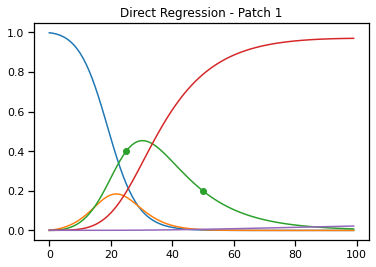

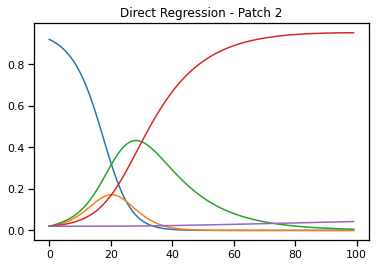

In [47]:
traj = reg_model.get_traj()
plt.plot(traj[0,:,0,:])
plt.plot(25, r1.target, 'o', color='C2')
plt.plot(50, r2.target, 'o', color='C2')
plt.title('Direct Regression - Patch 1')
plt.show()
traj = reg_model.get_traj()
plt.plot(traj[0,:,1,:])
plt.title('Direct Regression - Patch 2')
plt.show()

In [48]:
reg_model.summary()

Model: "trainable_meta_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
trainable_input_layer_1 (Tra multiple                  9         
_________________________________________________________________
trainable_input_layer_2 (Tra multiple                  16        
_________________________________________________________________
trainable_input_layer_3 (Tra multiple                  12        
_________________________________________________________________
metapop_layer_1 (MetapopLaye multiple                  1         
_________________________________________________________________
traj (AddSusceptibleLayer)   multiple                  0         
_________________________________________________________________
lambda (Lambda)              multiple                  0         
Total params: 38
Trainable params: 38
Non-trainable params: 0
__________________________________________________

In [49]:
reg_model.layers[0].trainable_weights

[<tf.Variable 'value:0' shape=(3, 3) dtype=float32, numpy=
 array([[0.2514207 , 0.08676298, 0.66181636],
        [0.3747877 , 0.3518197 , 0.2733926 ],
        [0.36558816, 0.29429075, 0.34012112]], dtype=float32)>]

In [50]:
reg_model.layers[1].trainable_weights

[<tf.Variable 'value:0' shape=(4, 4) dtype=float32, numpy=
 array([[7.3377281e-01, 2.6622716e-01, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 9.3431878e-01, 6.5681204e-02, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 9.9963325e-01, 3.6670169e-04],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 1.0000000e+00]],
       dtype=float32)>]

In [51]:
reg_model.layers[2].trainable_weights

[<tf.Variable 'value:0' shape=(3, 4) dtype=float32, numpy=
 array([[0.00014805, 0.00019659, 0.00056642, 0.00056642],
        [0.02005312, 0.02005311, 0.02005311, 0.02005312],
        [0.        , 0.        , 0.        , 0.        ]], dtype=float32)>]

In [52]:
reg_model.layers[2].w.constraint(reg_model.layers[2].w)

<tf.Tensor: shape=(3, 4), dtype=float32, numpy=
array([[0.00014805, 0.00019659, 0.00056642, 0.00056642],
       [0.02005312, 0.02005311, 0.02005311, 0.02005312],
       [0.        , 0.        , 0.        , 0.        ]], dtype=float32)>

In [53]:
reg_model.layers[2].w.constraint.get_config

<bound method Constraint.get_config of <maxentep.metapop_model.MinMaxConstraint object at 0x000001870746B108>>

In [54]:
reg_model.layers[2].w.constraint(reg_model.layers[2].w)

<tf.Tensor: shape=(3, 4), dtype=float32, numpy=
array([[0.00014805, 0.00019659, 0.00056642, 0.00056642],
       [0.02005312, 0.02005311, 0.02005311, 0.02005312],
       [0.        , 0.        , 0.        , 0.        ]], dtype=float32)>